In [14]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print(tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam

import matplotlib.pyplot as plt

from rbf_tf.rbflayer import RBFLayer, InitCentersRandom
from rbf_tf.kmeans_initializer import InitCentersKMeans

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTrain.head()

print(dataTrain.shape)
dataTrain.head()

<module 'tensorflow._api.v2.version' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
(3772, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [15]:
del dataTrain[22]
del dataTrain[23]

In [16]:
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [17]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)
inputTrain.head()        

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [18]:
#Target data
outputTrain = dataTrain[21] - 1
outputTrain.head()

0    2
1    2
2    2
3    2
4    2
Name: 21, dtype: int64

In [19]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [20]:
del dataTest[22]
del dataTest[23]

In [21]:
inputTest = dataTest.drop([21], axis=1)
outputTest = dataTest[21] - 1

In [22]:
scaler = preprocessing.MinMaxScaler()
# fit using the train set
scaler.fit(inputTrain)
# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

In [23]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

In [24]:
'''print("Proporção das classes no dataset")
counts = np.bincount(outputTrain)
print(counts)
print("Dados de Treinamento:",  counts/ float(len(outputTrain)))
print("Dados de Teste:", np.bincount(outputTest) / float(len(outputTest)))

peso_classe1 = 1.0/counts[0]
peso_classe2 = 1.0/counts[1]
peso_classe3 = 1.0/counts[2]
'''

class_weights = compute_class_weight('balanced', np.unique(outputTrain), outputTrain)
print(class_weights)
d_class_weights = dict(enumerate(class_weights))

[13.51971326  6.58289703  0.36047401]


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=0       2
1       2
2       2
3       2
4       2
       ..
3767    2
3768    2
3769    1
3770    2
3771    2
Name: 21, Length: 3772, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [25]:
 X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
     xtrainN, 
     outputTrain_one_hot, 
     test_size = 0.3, 
     random_state = 1, 
     stratify=outputTrain
 )  

In [26]:
# model = Sequential(
#     [
#         Dense(256, activation="relu", input_shape=(X_train.shape[-1],)
#         ),
#         Dense(256, activation="relu"),
#         Dropout(0.3),
#         Dense(256, activation="relu"),
#         Dropout(0.3),
#         Dense(3, activation="sigmoid"),
#     ]
# )
# model.summary()
model = Sequential(
    [
        keras.Input(shape=(X_train.shape[-1],)),
        RBFLayer(850,
                     initializer=InitCentersKMeans(X_train),
                      betas=15.0),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 850)               18700     
_________________________________________________________________
dense (Dense)                (None, 3)                 2553      
Total params: 21,253
Trainable params: 21,253
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
14/14 [==============================] - 8s 253ms/step - loss: 0.6685 - fn: 1524.6667 - fp: 1.7333 - tn: 3128.9333 - tp: 40.6667 - precision: 0.9547 - recall: 0.0261 - val_loss: 0.6146 - val_fn: 1095.0000 - val_fp: 1.0000 - val_tn: 2263.0000 - val_tp: 37.0000 - val_precision: 0.9737 - val_recall: 0.0327
Epoch 2/500
14/14 [==============================] - 1s 107ms/step - loss: 0.6140 - fn: 1423.3333 - fp: 57.2667 - tn: 3073.4000 - tp: 142.0000 - precision: 0.7801 - recall: 0.0762 - val_loss: 0.5906 - val_fn: 937.0000 - val_fp: 195.0000 - val_tn: 2069.0000 - val_tp: 195.0000 - val_precision: 0.5000 - val_recall: 0.1723
Epoch 3/500
14/14 [==============================] - 2s 113ms/step - loss: 0.6059 - fn: 1214.1333 - fp: 360.2667 - tn: 2770.4000 - tp: 351.2000 - precision: 0.5050 - recall: 0.2225 - val_loss: 0.5670 - val_fn: 860.0000 - val_fp: 298.0000 - val_tn: 1966.0000 - val_tp: 272.0000 - val_precision: 0.4772 - val_recall: 0.2403
Epoch 4/500
14/14 [=====================

14/14 [==============================] - 1s 107ms/step - loss: 0.3790 - fn: 533.0667 - fp: 307.5333 - tn: 2823.1333 - tp: 1032.2667 - precision: 0.7692 - recall: 0.6543 - val_loss: 0.4420 - val_fn: 430.0000 - val_fp: 251.0000 - val_tn: 2013.0000 - val_tp: 702.0000 - val_precision: 0.7366 - val_recall: 0.6201
Epoch 27/500
14/14 [==============================] - 1s 104ms/step - loss: 0.3718 - fn: 511.7333 - fp: 303.9333 - tn: 2826.7333 - tp: 1053.6000 - precision: 0.7699 - recall: 0.6697 - val_loss: 0.4324 - val_fn: 404.0000 - val_fp: 226.0000 - val_tn: 2038.0000 - val_tp: 728.0000 - val_precision: 0.7631 - val_recall: 0.6431
Epoch 28/500
14/14 [==============================] - 2s 111ms/step - loss: 0.3641 - fn: 492.4667 - fp: 283.8000 - tn: 2846.8667 - tp: 1072.8667 - precision: 0.7914 - recall: 0.6868 - val_loss: 0.4342 - val_fn: 409.0000 - val_fp: 232.0000 - val_tn: 2032.0000 - val_tp: 723.0000 - val_precision: 0.7571 - val_recall: 0.6387
Epoch 29/500
14/14 [========================

14/14 [==============================] - 1s 100ms/step - loss: 0.3239 - fn: 424.5333 - fp: 296.4667 - tn: 2834.2000 - tp: 1140.8000 - precision: 0.7998 - recall: 0.7363 - val_loss: 0.4106 - val_fn: 362.0000 - val_fp: 246.0000 - val_tn: 2018.0000 - val_tp: 770.0000 - val_precision: 0.7579 - val_recall: 0.6802
Epoch 52/500
14/14 [==============================] - 1s 101ms/step - loss: 0.3388 - fn: 444.4000 - fp: 309.0667 - tn: 2821.6000 - tp: 1120.9333 - precision: 0.7810 - recall: 0.7109 - val_loss: 0.4117 - val_fn: 373.0000 - val_fp: 250.0000 - val_tn: 2014.0000 - val_tp: 759.0000 - val_precision: 0.7522 - val_recall: 0.6705
Epoch 53/500
14/14 [==============================] - 1s 101ms/step - loss: 0.3168 - fn: 443.5333 - fp: 311.4667 - tn: 2819.2000 - tp: 1121.8000 - precision: 0.7815 - recall: 0.7148 - val_loss: 0.4100 - val_fn: 364.0000 - val_fp: 246.0000 - val_tn: 2018.0000 - val_tp: 768.0000 - val_precision: 0.7574 - val_recall: 0.6784
Epoch 54/500
14/14 [========================

14/14 [==============================] - 1s 102ms/step - loss: 0.2859 - fn: 397.4000 - fp: 294.7333 - tn: 2835.9333 - tp: 1167.9333 - precision: 0.7970 - recall: 0.7433 - val_loss: 0.3858 - val_fn: 326.0000 - val_fp: 239.0000 - val_tn: 2025.0000 - val_tp: 806.0000 - val_precision: 0.7713 - val_recall: 0.7120
Epoch 77/500
14/14 [==============================] - 1s 102ms/step - loss: 0.3030 - fn: 405.4000 - fp: 305.2667 - tn: 2825.4000 - tp: 1159.9333 - precision: 0.7943 - recall: 0.7403 - val_loss: 0.3977 - val_fn: 346.0000 - val_fp: 258.0000 - val_tn: 2006.0000 - val_tp: 786.0000 - val_precision: 0.7529 - val_recall: 0.6943
Epoch 78/500
14/14 [==============================] - 1s 100ms/step - loss: 0.2927 - fn: 407.4667 - fp: 318.4667 - tn: 2812.2000 - tp: 1157.8667 - precision: 0.7765 - recall: 0.7308 - val_loss: 0.3882 - val_fn: 330.0000 - val_fp: 246.0000 - val_tn: 2018.0000 - val_tp: 802.0000 - val_precision: 0.7653 - val_recall: 0.7085
Epoch 79/500
14/14 [========================

14/14 [==============================] - 1s 83ms/step - loss: 0.2860 - fn: 404.1333 - fp: 326.8000 - tn: 2803.8667 - tp: 1161.2000 - precision: 0.7844 - recall: 0.7448 - val_loss: 0.3884 - val_fn: 338.0000 - val_fp: 258.0000 - val_tn: 2006.0000 - val_tp: 794.0000 - val_precision: 0.7548 - val_recall: 0.7014
Epoch 102/500
14/14 [==============================] - 1s 81ms/step - loss: 0.2718 - fn: 372.1333 - fp: 293.3333 - tn: 2837.3333 - tp: 1193.2000 - precision: 0.7972 - recall: 0.7586 - val_loss: 0.3679 - val_fn: 306.0000 - val_fp: 224.0000 - val_tn: 2040.0000 - val_tp: 826.0000 - val_precision: 0.7867 - val_recall: 0.7297
Epoch 103/500
14/14 [==============================] - 1s 88ms/step - loss: 0.2814 - fn: 351.8667 - fp: 272.6000 - tn: 2858.0667 - tp: 1213.4667 - precision: 0.8213 - recall: 0.7798 - val_loss: 0.3728 - val_fn: 306.0000 - val_fp: 226.0000 - val_tn: 2038.0000 - val_tp: 826.0000 - val_precision: 0.7852 - val_recall: 0.7297
Epoch 104/500
14/14 [========================

14/14 [==============================] - 1s 97ms/step - loss: 0.2685 - fn: 369.8000 - fp: 309.4667 - tn: 2821.2000 - tp: 1195.5333 - precision: 0.7990 - recall: 0.7694 - val_loss: 0.3724 - val_fn: 323.0000 - val_fp: 249.0000 - val_tn: 2015.0000 - val_tp: 809.0000 - val_precision: 0.7647 - val_recall: 0.7147
Epoch 127/500
14/14 [==============================] - 1s 101ms/step - loss: 0.2751 - fn: 368.4000 - fp: 308.0000 - tn: 2822.6667 - tp: 1196.9333 - precision: 0.7948 - recall: 0.7642 - val_loss: 0.3655 - val_fn: 301.0000 - val_fp: 228.0000 - val_tn: 2036.0000 - val_tp: 831.0000 - val_precision: 0.7847 - val_recall: 0.7341
Epoch 128/500
14/14 [==============================] - 1s 101ms/step - loss: 0.2715 - fn: 389.0667 - fp: 327.7333 - tn: 2802.9333 - tp: 1176.2667 - precision: 0.7826 - recall: 0.7510 - val_loss: 0.3780 - val_fn: 329.0000 - val_fp: 256.0000 - val_tn: 2008.0000 - val_tp: 803.0000 - val_precision: 0.7583 - val_recall: 0.7094
Epoch 129/500
14/14 [======================

14/14 [==============================] - 1s 101ms/step - loss: 0.2582 - fn: 377.2667 - fp: 325.6667 - tn: 2805.0000 - tp: 1188.0667 - precision: 0.7764 - recall: 0.7507 - val_loss: 0.3631 - val_fn: 305.0000 - val_fp: 236.0000 - val_tn: 2028.0000 - val_tp: 827.0000 - val_precision: 0.7780 - val_recall: 0.7306
Epoch 152/500
14/14 [==============================] - 1s 101ms/step - loss: 0.2317 - fn: 323.7333 - fp: 277.0000 - tn: 2853.6667 - tp: 1241.6000 - precision: 0.8132 - recall: 0.7887 - val_loss: 0.3621 - val_fn: 294.0000 - val_fp: 228.0000 - val_tn: 2036.0000 - val_tp: 838.0000 - val_precision: 0.7861 - val_recall: 0.7403
Epoch 153/500
14/14 [==============================] - 48s 4s/step - loss: 0.2636 - fn: 386.6000 - fp: 338.2000 - tn: 2792.4667 - tp: 1178.7333 - precision: 0.7798 - recall: 0.7560 - val_loss: 0.3772 - val_fn: 329.0000 - val_fp: 264.0000 - val_tn: 2000.0000 - val_tp: 803.0000 - val_precision: 0.7526 - val_recall: 0.7094
Epoch 154/500
14/14 [=======================

14/14 [==============================] - 2s 129ms/step - loss: 0.2391 - fn: 305.8667 - fp: 269.4000 - tn: 2861.2667 - tp: 1259.4667 - precision: 0.8182 - recall: 0.7999 - val_loss: 0.3388 - val_fn: 269.0000 - val_fp: 212.0000 - val_tn: 2052.0000 - val_tp: 863.0000 - val_precision: 0.8028 - val_recall: 0.7624
Epoch 177/500
14/14 [==============================] - 2s 135ms/step - loss: 0.2410 - fn: 323.6000 - fp: 281.6667 - tn: 2849.0000 - tp: 1241.7333 - precision: 0.8129 - recall: 0.7898 - val_loss: 0.3488 - val_fn: 280.0000 - val_fp: 223.0000 - val_tn: 2041.0000 - val_tp: 852.0000 - val_precision: 0.7926 - val_recall: 0.7527
Epoch 178/500
14/14 [==============================] - 2s 173ms/step - loss: 0.2346 - fn: 317.2000 - fp: 276.0000 - tn: 2854.6667 - tp: 1248.1333 - precision: 0.8226 - recall: 0.8002 - val_loss: 0.3466 - val_fn: 269.0000 - val_fp: 215.0000 - val_tn: 2049.0000 - val_tp: 863.0000 - val_precision: 0.8006 - val_recall: 0.7624
Epoch 179/500
14/14 [=====================

14/14 [==============================] - 2s 167ms/step - loss: 0.2368 - fn: 341.2000 - fp: 296.5333 - tn: 2834.1333 - tp: 1224.1333 - precision: 0.8042 - recall: 0.7808 - val_loss: 0.3550 - val_fn: 295.0000 - val_fp: 241.0000 - val_tn: 2023.0000 - val_tp: 837.0000 - val_precision: 0.7764 - val_recall: 0.7394
Epoch 202/500
14/14 [==============================] - 2s 164ms/step - loss: 0.2365 - fn: 345.0000 - fp: 300.8667 - tn: 2829.8000 - tp: 1220.3333 - precision: 0.8069 - recall: 0.7835 - val_loss: 0.3472 - val_fn: 275.0000 - val_fp: 217.0000 - val_tn: 2047.0000 - val_tp: 857.0000 - val_precision: 0.7980 - val_recall: 0.7571
Epoch 203/500
14/14 [==============================] - 2s 163ms/step - loss: 0.2367 - fn: 299.7333 - fp: 264.3333 - tn: 2866.3333 - tp: 1265.6000 - precision: 0.8262 - recall: 0.8081 - val_loss: 0.3349 - val_fn: 250.0000 - val_fp: 195.0000 - val_tn: 2069.0000 - val_tp: 882.0000 - val_precision: 0.8189 - val_recall: 0.7792
Epoch 204/500
14/14 [=====================

14/14 [==============================] - 2s 162ms/step - loss: 0.2394 - fn: 327.3333 - fp: 291.6000 - tn: 2839.0667 - tp: 1238.0000 - precision: 0.8025 - recall: 0.7832 - val_loss: 0.3402 - val_fn: 267.0000 - val_fp: 213.0000 - val_tn: 2051.0000 - val_tp: 865.0000 - val_precision: 0.8024 - val_recall: 0.7641
Epoch 227/500
14/14 [==============================] - 2s 151ms/step - loss: 0.2298 - fn: 315.2667 - fp: 283.4000 - tn: 2847.2667 - tp: 1250.0667 - precision: 0.8089 - recall: 0.7936 - val_loss: 0.3422 - val_fn: 275.0000 - val_fp: 220.0000 - val_tn: 2044.0000 - val_tp: 857.0000 - val_precision: 0.7957 - val_recall: 0.7571
Epoch 228/500
14/14 [==============================] - 2s 155ms/step - loss: 0.2211 - fn: 307.0000 - fp: 272.9333 - tn: 2857.7333 - tp: 1258.3333 - precision: 0.8186 - recall: 0.8010 - val_loss: 0.3393 - val_fn: 263.0000 - val_fp: 211.0000 - val_tn: 2053.0000 - val_tp: 869.0000 - val_precision: 0.8046 - val_recall: 0.7677
Epoch 229/500
14/14 [=====================

14/14 [==============================] - 5s 359ms/step - loss: 0.2251 - fn: 302.2667 - fp: 267.0000 - tn: 2863.6667 - tp: 1263.0667 - precision: 0.8309 - recall: 0.8146 - val_loss: 0.3401 - val_fn: 271.0000 - val_fp: 221.0000 - val_tn: 2043.0000 - val_tp: 861.0000 - val_precision: 0.7957 - val_recall: 0.7606
Epoch 252/500
14/14 [==============================] - 9s 635ms/step - loss: 0.2214 - fn: 308.2000 - fp: 271.0667 - tn: 2859.6000 - tp: 1257.1333 - precision: 0.8130 - recall: 0.7940 - val_loss: 0.3286 - val_fn: 250.0000 - val_fp: 207.0000 - val_tn: 2057.0000 - val_tp: 882.0000 - val_precision: 0.8099 - val_recall: 0.7792
Epoch 253/500
14/14 [==============================] - 4s 260ms/step - loss: 0.2255 - fn: 297.0000 - fp: 262.0000 - tn: 2868.6667 - tp: 1268.3333 - precision: 0.8321 - recall: 0.8144 - val_loss: 0.3302 - val_fn: 249.0000 - val_fp: 202.0000 - val_tn: 2062.0000 - val_tp: 883.0000 - val_precision: 0.8138 - val_recall: 0.7800
Epoch 254/500
14/14 [=====================

14/14 [==============================] - 1s 96ms/step - loss: 0.2156 - fn: 241.4667 - fp: 211.0667 - tn: 2919.6000 - tp: 1323.8667 - precision: 0.8628 - recall: 0.8477 - val_loss: 0.3110 - val_fn: 225.0000 - val_fp: 180.0000 - val_tn: 2084.0000 - val_tp: 907.0000 - val_precision: 0.8344 - val_recall: 0.8012
Epoch 277/500
14/14 [==============================] - 2s 147ms/step - loss: 0.2025 - fn: 256.7333 - fp: 226.3333 - tn: 2904.3333 - tp: 1308.6000 - precision: 0.8488 - recall: 0.8328 - val_loss: 0.3119 - val_fn: 227.0000 - val_fp: 180.0000 - val_tn: 2084.0000 - val_tp: 905.0000 - val_precision: 0.8341 - val_recall: 0.7995
Epoch 278/500
14/14 [==============================] - 4s 261ms/step - loss: 0.2335 - fn: 273.0000 - fp: 241.6667 - tn: 2889.0000 - tp: 1292.3333 - precision: 0.8403 - recall: 0.8243 - val_loss: 0.3255 - val_fn: 240.0000 - val_fp: 193.0000 - val_tn: 2071.0000 - val_tp: 892.0000 - val_precision: 0.8221 - val_recall: 0.7880
Epoch 279/500
14/14 [======================

14/14 [==============================] - 1s 97ms/step - loss: 0.2066 - fn: 280.9333 - fp: 249.7333 - tn: 2880.9333 - tp: 1284.4000 - precision: 0.8435 - recall: 0.8267 - val_loss: 0.3283 - val_fn: 257.0000 - val_fp: 209.0000 - val_tn: 2055.0000 - val_tp: 875.0000 - val_precision: 0.8072 - val_recall: 0.7730
Epoch 302/500
14/14 [==============================] - 1s 99ms/step - loss: 0.1958 - fn: 255.0667 - fp: 223.1333 - tn: 2907.5333 - tp: 1310.2667 - precision: 0.8535 - recall: 0.8381 - val_loss: 0.3141 - val_fn: 225.0000 - val_fp: 179.0000 - val_tn: 2085.0000 - val_tp: 907.0000 - val_precision: 0.8352 - val_recall: 0.8012
Epoch 303/500
14/14 [==============================] - 1s 100ms/step - loss: 0.2091 - fn: 259.0000 - fp: 230.2667 - tn: 2900.4000 - tp: 1306.3333 - precision: 0.8510 - recall: 0.8367 - val_loss: 0.3217 - val_fn: 242.0000 - val_fp: 197.0000 - val_tn: 2067.0000 - val_tp: 890.0000 - val_precision: 0.8188 - val_recall: 0.7862
Epoch 304/500
14/14 [=======================

14/14 [==============================] - 1s 104ms/step - loss: 0.1888 - fn: 225.2000 - fp: 196.2000 - tn: 2934.4667 - tp: 1340.1333 - precision: 0.8770 - recall: 0.8622 - val_loss: 0.3197 - val_fn: 232.0000 - val_fp: 184.0000 - val_tn: 2080.0000 - val_tp: 900.0000 - val_precision: 0.8303 - val_recall: 0.7951
Epoch 327/500
14/14 [==============================] - 1s 104ms/step - loss: 0.2044 - fn: 254.4000 - fp: 219.8667 - tn: 2910.8000 - tp: 1310.9333 - precision: 0.8561 - recall: 0.8373 - val_loss: 0.3148 - val_fn: 225.0000 - val_fp: 177.0000 - val_tn: 2087.0000 - val_tp: 907.0000 - val_precision: 0.8367 - val_recall: 0.8012
Epoch 328/500
14/14 [==============================] - 1s 104ms/step - loss: 0.1935 - fn: 239.0667 - fp: 209.4000 - tn: 2921.2667 - tp: 1326.2667 - precision: 0.8648 - recall: 0.8495 - val_loss: 0.3032 - val_fn: 209.0000 - val_fp: 166.0000 - val_tn: 2098.0000 - val_tp: 923.0000 - val_precision: 0.8476 - val_recall: 0.8154
Epoch 329/500
14/14 [=====================

14/14 [==============================] - 1s 104ms/step - loss: 0.1932 - fn: 268.8000 - fp: 239.1333 - tn: 2891.5333 - tp: 1296.5333 - precision: 0.8432 - recall: 0.8283 - val_loss: 0.3135 - val_fn: 226.0000 - val_fp: 183.0000 - val_tn: 2081.0000 - val_tp: 906.0000 - val_precision: 0.8320 - val_recall: 0.8004
Epoch 352/500
14/14 [==============================] - 1s 103ms/step - loss: 0.1995 - fn: 281.2000 - fp: 251.6667 - tn: 2879.0000 - tp: 1284.1333 - precision: 0.8339 - recall: 0.8185 - val_loss: 0.3185 - val_fn: 242.0000 - val_fp: 194.0000 - val_tn: 2070.0000 - val_tp: 890.0000 - val_precision: 0.8210 - val_recall: 0.7862
Epoch 353/500
14/14 [==============================] - 1s 108ms/step - loss: 0.1935 - fn: 247.8667 - fp: 218.2667 - tn: 2912.4000 - tp: 1317.4667 - precision: 0.8515 - recall: 0.8366 - val_loss: 0.3156 - val_fn: 230.0000 - val_fp: 182.0000 - val_tn: 2082.0000 - val_tp: 902.0000 - val_precision: 0.8321 - val_recall: 0.7968
Epoch 354/500
14/14 [=====================

14/14 [==============================] - 1s 82ms/step - loss: 0.1932 - fn: 268.4000 - fp: 239.0000 - tn: 2891.6667 - tp: 1296.9333 - precision: 0.8511 - recall: 0.8361 - val_loss: 0.3098 - val_fn: 222.0000 - val_fp: 181.0000 - val_tn: 2083.0000 - val_tp: 910.0000 - val_precision: 0.8341 - val_recall: 0.8039
Epoch 377/500
14/14 [==============================] - 1s 83ms/step - loss: 0.1907 - fn: 226.0000 - fp: 199.0667 - tn: 2931.6000 - tp: 1339.3333 - precision: 0.8716 - recall: 0.8576 - val_loss: 0.2975 - val_fn: 208.0000 - val_fp: 167.0000 - val_tn: 2097.0000 - val_tp: 924.0000 - val_precision: 0.8469 - val_recall: 0.8163
Epoch 378/500
14/14 [==============================] - 1s 83ms/step - loss: 0.1794 - fn: 228.6667 - fp: 196.6667 - tn: 2934.0000 - tp: 1336.6667 - precision: 0.8737 - recall: 0.8554 - val_loss: 0.3124 - val_fn: 218.0000 - val_fp: 180.0000 - val_tn: 2084.0000 - val_tp: 914.0000 - val_precision: 0.8355 - val_recall: 0.8074
Epoch 379/500
14/14 [========================

14/14 [==============================] - 1s 99ms/step - loss: 0.1787 - fn: 242.5333 - fp: 212.4667 - tn: 2918.2000 - tp: 1322.8000 - precision: 0.8619 - recall: 0.8445 - val_loss: 0.3031 - val_fn: 210.0000 - val_fp: 173.0000 - val_tn: 2091.0000 - val_tp: 922.0000 - val_precision: 0.8420 - val_recall: 0.8145
Epoch 402/500
14/14 [==============================] - 1s 100ms/step - loss: 0.1813 - fn: 233.2000 - fp: 199.7333 - tn: 2930.9333 - tp: 1332.1333 - precision: 0.8747 - recall: 0.8553 - val_loss: 0.3086 - val_fn: 218.0000 - val_fp: 181.0000 - val_tn: 2083.0000 - val_tp: 914.0000 - val_precision: 0.8347 - val_recall: 0.8074
Epoch 403/500
14/14 [==============================] - 1s 99ms/step - loss: 0.1967 - fn: 239.3333 - fp: 210.8667 - tn: 2919.8000 - tp: 1326.0000 - precision: 0.8549 - recall: 0.8404 - val_loss: 0.3065 - val_fn: 207.0000 - val_fp: 168.0000 - val_tn: 2096.0000 - val_tp: 925.0000 - val_precision: 0.8463 - val_recall: 0.8171
Epoch 404/500
14/14 [=======================

14/14 [==============================] - 1s 99ms/step - loss: 0.1782 - fn: 208.6667 - fp: 182.2000 - tn: 2948.4667 - tp: 1356.6667 - precision: 0.8879 - recall: 0.8729 - val_loss: 0.2998 - val_fn: 215.0000 - val_fp: 179.0000 - val_tn: 2085.0000 - val_tp: 917.0000 - val_precision: 0.8367 - val_recall: 0.8101
Epoch 427/500
14/14 [==============================] - 1s 101ms/step - loss: 0.1837 - fn: 222.6667 - fp: 197.2667 - tn: 2933.4000 - tp: 1342.6667 - precision: 0.8684 - recall: 0.8541 - val_loss: 0.2931 - val_fn: 208.0000 - val_fp: 172.0000 - val_tn: 2092.0000 - val_tp: 924.0000 - val_precision: 0.8431 - val_recall: 0.8163
Epoch 428/500
14/14 [==============================] - 1s 100ms/step - loss: 0.1822 - fn: 243.0667 - fp: 217.9333 - tn: 2912.7333 - tp: 1322.2667 - precision: 0.8642 - recall: 0.8502 - val_loss: 0.2874 - val_fn: 193.0000 - val_fp: 155.0000 - val_tn: 2109.0000 - val_tp: 939.0000 - val_precision: 0.8583 - val_recall: 0.8295
Epoch 429/500
14/14 [======================

14/14 [==============================] - 1s 101ms/step - loss: 0.1715 - fn: 230.7333 - fp: 206.6667 - tn: 2924.0000 - tp: 1334.6000 - precision: 0.8709 - recall: 0.8571 - val_loss: 0.2902 - val_fn: 197.0000 - val_fp: 163.0000 - val_tn: 2101.0000 - val_tp: 935.0000 - val_precision: 0.8515 - val_recall: 0.8260
Epoch 452/500
14/14 [==============================] - 1s 105ms/step - loss: 0.1679 - fn: 200.8000 - fp: 176.3333 - tn: 2954.3333 - tp: 1364.5333 - precision: 0.8833 - recall: 0.8696 - val_loss: 0.3195 - val_fn: 243.0000 - val_fp: 207.0000 - val_tn: 2057.0000 - val_tp: 889.0000 - val_precision: 0.8111 - val_recall: 0.7853
Epoch 453/500
14/14 [==============================] - 1s 101ms/step - loss: 0.1842 - fn: 270.3333 - fp: 246.6000 - tn: 2884.0667 - tp: 1295.0000 - precision: 0.8374 - recall: 0.8249 - val_loss: 0.2758 - val_fn: 180.0000 - val_fp: 146.0000 - val_tn: 2118.0000 - val_tp: 952.0000 - val_precision: 0.8670 - val_recall: 0.8410
Epoch 454/500
14/14 [=====================

14/14 [==============================] - 1s 106ms/step - loss: 0.1835 - fn: 199.7333 - fp: 179.0667 - tn: 2951.6000 - tp: 1365.6000 - precision: 0.8801 - recall: 0.8681 - val_loss: 0.2750 - val_fn: 172.0000 - val_fp: 138.0000 - val_tn: 2126.0000 - val_tp: 960.0000 - val_precision: 0.8743 - val_recall: 0.8481
Epoch 477/500
14/14 [==============================] - 1s 107ms/step - loss: 0.1743 - fn: 217.6000 - fp: 197.9333 - tn: 2932.7333 - tp: 1347.7333 - precision: 0.8722 - recall: 0.8620 - val_loss: 0.2864 - val_fn: 189.0000 - val_fp: 154.0000 - val_tn: 2110.0000 - val_tp: 943.0000 - val_precision: 0.8596 - val_recall: 0.8330
Epoch 478/500
14/14 [==============================] - 2s 116ms/step - loss: 0.1683 - fn: 187.8000 - fp: 163.2000 - tn: 2967.4667 - tp: 1377.5333 - precision: 0.8966 - recall: 0.8822 - val_loss: 0.2754 - val_fn: 176.0000 - val_fp: 143.0000 - val_tn: 2121.0000 - val_tp: 956.0000 - val_precision: 0.8699 - val_recall: 0.8445
Epoch 479/500
14/14 [=====================

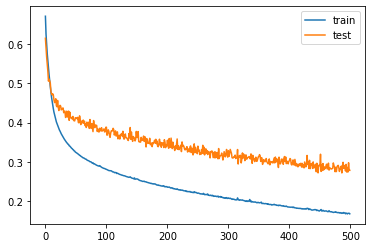

In [27]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("thyroid_model_at_epoch_{epoch}.h5")]

history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs=500,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=d_class_weights,
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [28]:
TrainPredictions = model.predict(inputTrain)
TrainPredictions = np.argmax(TrainPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

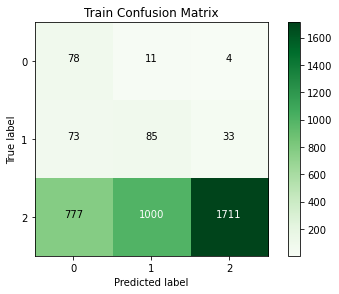

In [29]:
conf = confusion_matrix(outputTrain, TrainPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [30]:
print('Confusion Matrix\n')
print(conf)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTrain, TrainPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTrain, TrainPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTrain, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  78   11    4]
 [  73   85   33]
 [ 777 1000 1711]]

Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.38
Macro Recall: 0.59
Macro F1-score: 0.31

Weighted Precision: 0.91
Weighted Recall: 0.50
Weighted F1-score: 0.61

Classification Report

              precision    recall  f1-score   support

     Class 1       0.08      0.84      0.15        93
     Class 2       0.08      0.45      0.13       191
     Class 3       0.98      0.49      0.65      3488

    accuracy                           0.50      3772
   macro avg       0.38      0.59      0.31      3772
weighted avg       0.91      0.50      0.61      3772



In [31]:
TestPredictions = model.predict(inputTest)
TestPredictions = np.argmax(TestPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

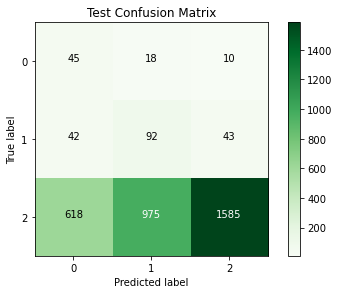

In [32]:
conf = confusion_matrix(outputTest, TestPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [33]:
print('Confusion Matrix\n')
print(conf)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTest, TestPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTest, TestPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTest, TestPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  45   18   10]
 [  42   92   43]
 [ 618  975 1585]]

Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.37
Macro Recall: 0.54
Macro F1-score: 0.31

Weighted Precision: 0.90
Weighted Recall: 0.50
Weighted F1-score: 0.62

Classification Report

              precision    recall  f1-score   support

     Class 1       0.06      0.62      0.12        73
     Class 2       0.08      0.52      0.15       177
     Class 3       0.97      0.50      0.66      3178

    accuracy                           0.50      3428
   macro avg       0.37      0.54      0.31      3428
weighted avg       0.90      0.50      0.62      3428

